## Prediction of user Knowledge

**Introduction**

The data set records the standardized results of study time, repetition, exam performance for the goal subject as well as non-goal but related subjects. It has a target value of user knowledge classified as very low, low, middle, or high. 

Research question: How can The degree of study time of user for related objects with goal object and exam performance on the goal object predict user knowledge?

The data set we will be using is taken from the UCI Machine learning repository titled, “User Knowledge Modeling Data Set”. The training data set contains 258 observations. There are 6 variables measured: STG (The degree of study time for goal object materials), SCG (The degree of repetition number of user for goal object materials), STR (The degree of study time of user for related objects with goal object), LPR (The exam performance of user for related objects with goal object), and PEG (The exam performance of user for goal object). Each of the variables are standardized. (Kahraman et Al.). There is research done on how general knowledge can be used to predict test scores (Hartwig et Al.), so in contrast, this data utilizes hard data such as test scores and studying time as the variables to something more abstract such as knowledge. 

In [68]:
#Required libraries 
import altair as alt
import pandas as pd 
import numpy as np
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)

## Methods

Firstly we wil create scatterplots with PEG on the y-axis and each of the other 4 variables with the shape and color aissgned by the UNS. Following this we identified that then We will use STR and PEG to predict. As these two variables are both focused on goal object, they provide a sense of coherence to the analysis. We will use the technique of classification on the training set to predict whether a new observation would be classified into one of the four categories of the knowledge level of the user.

We will plot the dataset as a scatterplot, with STR on the x-axis, PEG on the y-axis and we will use color and shape to distinct different categories of UNS. 

### Loads data from the original source on the web & cleans 

In [69]:
#importing the data set
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"

user_knowledge_data = pd.read_excel(url, sheet_name = 1).drop(columns = ["Unnamed: 6", "Unnamed: 7", "Attribute Information:"])
user_knowledge_data

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,very_low
1,0.08,0.08,0.10,0.24,0.90,High
2,0.06,0.06,0.05,0.25,0.33,Low
3,0.10,0.10,0.15,0.65,0.30,Middle
4,0.08,0.08,0.08,0.98,0.24,Low
...,...,...,...,...,...,...
253,0.61,0.78,0.69,0.92,0.58,High
254,0.78,0.61,0.71,0.19,0.60,Middle
255,0.54,0.82,0.71,0.29,0.77,High
256,0.50,0.75,0.81,0.61,0.26,Middle


### Summary of the data

In [70]:
user_knowledge_data.agg(["min", "max"])

,STG,SCG,STR,LPR,PEG,UNS
min,0.00,0.0,0.00,0.00,0.00,High
max,0.99,0.9,0.95,0.99,0.93,very_low


In [71]:
#UNS_data = user_knowledge_data[[" UNS"]]
data= user_knowledge_data.assign(count = 0)
data = data.iloc[:,5:7].groupby(" UNS").count().reset_index()
data

,UNS,count
0,High,63
1,Low,83
2,Middle,88
3,very_low,24


### Visualization of the dataset

In [72]:
user_chart = (
    alt.Chart(user_knowledge_data)
    .mark_point()
    .encode(
        x = alt.X("STG", title = "Study time for goal object (Standardized)"),
        y = alt.Y("PEG", title = "Exam performance for goal object (standardized)"),
        color = " UNS",
        shape = " UNS"
)).properties(width=400, height=400)
user_chart        

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [73]:
user_chart2 = (
    alt.Chart(user_knowledge_data)
    .mark_point()
    .encode(
        x = alt.X("SCG", title = "The degree of repetition number of user for goal object materials (Standardized)"),
        y = alt.Y("PEG", title = "Exam performance for goal object (standardized)"),
        color = " UNS",
        shape = " UNS"
)).properties(width=400, height=400)
user_chart2  

alt.Chart(...)

In [74]:
user_chart3 = (
    alt.Chart(user_knowledge_data)
    .mark_point()
    .encode(
        x = alt.X("STR", title = "The degree of study time of user for related objects with goal object(Standardized)"),
        y = alt.Y("PEG", title = "Exam performance for goal object (standardized)"),
        color = " UNS",
        shape = " UNS"
)).properties(width=400, height=400)
user_chart3

alt.Chart(...)

In [75]:
user_chart4 = (
    alt.Chart(user_knowledge_data)
    .mark_point()
    .encode(
        x = alt.X("LPR", title = "The exam performance of user for related objects with goal object(Standardized)"),
        y = alt.Y("PEG", title = "Exam performance for goal object (standardized)"),
        color = " UNS",
        shape = " UNS"
)).properties(width=400, height=400)
user_chart4  

alt.Chart(...)

### Data Analysis
#### split training set and testing set

In [76]:
usr_training, usr_test = train_test_split(user_knowledge_data,test_size=0.25,random_state=123)
print(usr_training.head())
print(usr_test.head())

       STG    SCG   STR   LPR   PEG       UNS
107  0.305  0.255  0.63  0.40  0.54    Middle
89   0.290  0.300  0.52  0.09  0.67    Middle
85   0.248  0.300  0.31  0.20  0.03  very_low
10   0.180  0.180  0.55  0.30  0.81      High
26   0.040  0.280  0.55  0.25  0.10  very_low
       STG    SCG   STR   LPR   PEG     UNS
30   0.120  0.245  0.75  0.31  0.59  Middle
100  0.270  0.280  0.18  0.48  0.26     Low
90   0.258  0.280  0.64  0.29  0.56  Middle
197  0.730  0.200  0.07  0.72  0.26     Low
198  0.780  0.150  0.38  0.18  0.63  Middle


#### Assign predictors and targets

In [77]:
X_train = pd.DataFrame(usr_training.loc[:,["STG","PEG"]])
y_train = usr_training.iloc[:,5:6]
X_test = pd.DataFrame(usr_test.loc[:,["STG","PEG"]])
y_test = usr_test.iloc[:,5:6]


#### Pick K-value using GridSearch

In [78]:
'''
Create prepocessor, pipeline, and knn
'''
usr_data_prepocessor = make_column_transformer((StandardScaler(),["STG","PEG"]),)
knn = KNeighborsClassifier()
usr_data_pipe = make_pipeline(usr_data_prepocessor,knn)


param_grid = {"kneighborsclassifier__n_neighbors": range(2, 50, 1),}

In [79]:
'''
Create grid search
'''
usr_data_tune_grid = GridSearchCV(
    estimator=usr_data_pipe, param_grid=param_grid, cv=5
)
usr_data_tune_grid

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['STG',
                                                                          'PEG'])])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': range(2, 50)})

In [80]:
'''
Fit the model to the data
'''
usr_data_model_grid = usr_data_tune_grid.fit(X_train,y_train)
accruacies_grid = pd.DataFrame(usr_data_model_grid.cv_results_)
accruacies_grid.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neighb

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001925,0.000468,0.001500,0.000179,2,{'kneighborsclassifier__n_neighbors': 2},0.794872,0.564103,0.641026,0.763158,0.736842,0.700000,0.085197,48
1,0.001492,0.000233,0.001343,0.000187,3,{'kneighborsclassifier__n_neighbors': 3},0.820513,0.794872,0.717949,0.789474,0.815789,0.787719,0.036839,10
2,0.001321,0.000134,0.001242,0.000114,4,{'kneighborsclassifier__n_neighbors': 4},0.794872,0.743590,0.769231,0.789474,0.789474,0.777328,0.019009,29
3,0.001460,0.000184,0.001302,0.000158,5,{'kneighborsclassifier__n_neighbors': 5},0.820513,0.769231,0.666667,0.868421,0.789474,0.782861,0.067036,13
4,0.001406,0.000143,0.001288,0.000128,6,{'kneighborsclassifier__n_neighbors': 6},0.820513,0.820513,0.692308,0.815789,0.789474,0.787719,0.049082,10


In [81]:
'''
Plot the accuracy against k to find the ideal k value
'''
accuracy_versus_k_grid = (
    alt.Chart(accruacies_grid, title="Grid Search")
    .mark_line(point=True)
    .encode(
        x=alt.X(
            "param_kneighborsclassifier__n_neighbors",
            title="Neighbors",
            scale=alt.Scale(zero=False),
        ),
        y=alt.Y(
            "mean_test_score", 
            title="Mean Test Score", 
            scale=alt.Scale(zero=False)
        ),
    )
    .configure_axis(labelFontSize=10, titleFontSize=15)
    .properties(width=800, height=600)
)
accuracy_versus_k_grid

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

It is trivial from the above plot that when $k=10$ or $k=13$, the mean test score is the highest. $\\$
(Test the model with GridSearchRange from $2$ to $100$, and the mean test score continues to drop after $k=50$, for better view of the plot, just pick the range from $2$ to $50$)

#### Set the model for K=10

In [82]:
'''
create knn, pipeline
'''
knn_spec = KNeighborsClassifier(n_neighbors=10)
usr_data_fit = make_pipeline(usr_data_prepocessor,knn_spec).fit(X_train,y_train)
usr_data_fit

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['STG', 'PEG'])])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=10))])

In [83]:
'''
user the model to predict test data and calculate the accuracy of the model
'''
usr_data_test_predictions = usr_test.assign(predictions=usr_data_fit.predict(X_test))

X_test_pred = usr_data_test_predictions[["STG","PEG"]]
y_test_pred = usr_data_test_predictions[" UNS"]
usr_data_pred_accuracy = usr_data_fit.score(X_test_pred,y_test_pred)
usr_data_pred_accuracy


0.8153846153846154

#### Set model for K=13

In [84]:
knn_spec_13 = KNeighborsClassifier(n_neighbors=13)
usr_data_fit_13 = make_pipeline(usr_data_prepocessor,knn_spec_13).fit(X_train,y_train)
usr_data_fit_13

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['STG', 'PEG'])])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=13))])

In [85]:
usr_data_test_predictions_13 = usr_test.assign(predictions=usr_data_fit_13.predict(X_test))

X_test_pred_13 = usr_data_test_predictions_13[["STG","PEG"]]
y_test_pred_13 = usr_data_test_predictions_13[" UNS"]
usr_data_pred_accuracy_13 = usr_data_fit_13.score(X_test_pred_13,y_test_pred_13)
usr_data_pred_accuracy_13

0.8

Since the accuracy score of $K=10$ is slightly higher than $K=13$, so we will use $K=10$ 

#### Cross-Validation

In [86]:
'''
Check if the model is overfit
'''
np.random.seed(2020)
usr_data_vfold_score = cross_validate(estimator=usr_data_fit,X=X_train,y=y_train,return_train_score=True,)
pd.DataFrame(usr_data_vfold_score)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neighb

,fit_time,score_time,test_score,train_score
0,0.002293,0.001959,0.846154,0.805195
1,0.001590,0.001358,0.769231,0.824675
2,0.001931,0.001402,0.769231,0.837662
3,0.001472,0.001190,0.815789,0.806452
4,0.001997,0.001660,0.789474,0.825806


#### Visualization of the model

In [87]:
usr_data_mat = confusion_matrix(
    usr_data_test_predictions[" UNS"],  # true labels
    usr_data_test_predictions["predictions"],  # predicted labels
    labels=usr_data_fit.classes_, # specify the label for each class
)

usr_data_mat

array([[ 6,  0,  3,  0],
       [ 0, 26,  0,  1],
       [ 0,  4, 20,  0],
       [ 0,  4,  0,  1]])

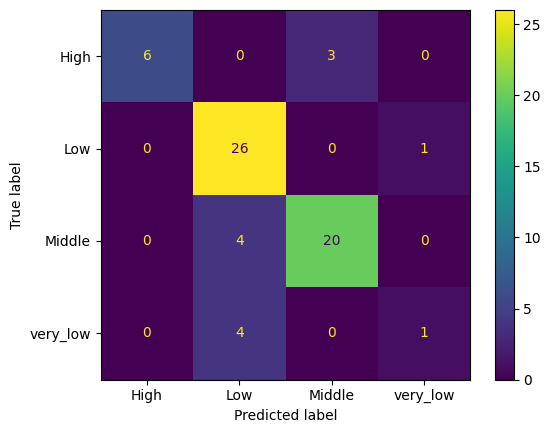

In [88]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(
    confusion_matrix=usr_data_mat, display_labels=usr_data_fit.classes_
)
disp.plot()

**Expected Outcomes and Significance**

In [89]:
'''
Check if the model is overfit
'''
np.random.seed(2020)
usr_data_vfold_score = cross_validate(estimator=usr_data_fit,X=X_train,y=y_train,return_train_score=True,)
pd.DataFrame(usr_data_vfold_score)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neighb

,fit_time,score_time,test_score,train_score
0,0.003245,0.002842,0.846154,0.805195
1,0.001705,0.001837,0.769231,0.824675
2,0.001551,0.001291,0.769231,0.837662
3,0.001460,0.001245,0.815789,0.806452
4,0.001571,0.001753,0.789474,0.825806



We expect that by using the two variables for The degree of study time with goal object (STR) and Exam performance of users (PEG) we would be able to predict the possible knowledge level of the user(UNS). Since there is a clear distinction between the levels of knowledge in the scatter plot provided we believe using K nearest neighbours would provide an accurate prediction for the users knowledge level.

Our findings could assess common methods for classifying students in settings where knowledge is heavily based on test scores such as in high school and in university. We can find if different variables such as test scores on the target object as well as study time with goal object accurately predict knowledge and how that can be translated to the system that schools currently use and if they are reliable and viable. 

One straightforward question may be “Are there any variables that could improve the accuracy of the prediction?”, as we are now using only two out of five variables to predict. Further down this path, another example of a potential future question could be, “Are Degree of Study time(STR) and Exam performance of users (PEG) the most two determinant variables among the five input variables for deciding a user’s knowledge level?” In an attempt to find the most accurate prediction, one may proceed by choosing variables to build the model and compare it with this one.

